## 📁 Regressão Logística - Base Original (sem acréscimo das subcategorias de estratégias)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Lê o arquivo Excel
df = pd.read_excel('dados_UFV_comp_original_tratados.xlsx', engine='openpyxl')

# Visualiza as primeiras linhas
df.head()

,Ano_Nascimento,Sexo,Campus,Curso,UF_Nascimento,Admissao,Saida,Situacao_Aluno_Agrupada,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA,Regiao_Nascimento
0,1996,1,0,0,0,0,0,0,1,671,20,0,56,1
1,1996,0,0,0,0,1,1,1,9,683,9,0,63,1
2,1982,1,0,0,0,2,2,0,9,706,5,0,0,1
3,1993,1,0,0,1,3,3,0,0,629,1,1,66,2
4,1996,1,0,0,0,0,4,1,9,629,21,2,58,1


### 2️⃣ Regressão Logística

#### Considerando todas as 4 classes:

##### Sem validação cruzada

A LogisticRegression precisa de um número maior de iterações (max_iter=1000) para garantir convergência em datasets maiores ou mais complexos.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.utils.multiclass import unique_labels
import numpy as np

# Separar features (X) e target (y)
X = df.drop(columns=["Situacao_Aluno_Agrupada"])
y = df["Situacao_Aluno_Agrupada"]

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo de regressão logística
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Fazer predições
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)  # Matriz de probabilidades preditas para todas as classes

# Avaliar métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
auc_score = roc_auc_score(y_test, y_proba, multi_class="ovr", average="weighted")

# Exibir resultados
print("Métricas de Avaliação:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc_score:.4f}")

# Exibir relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

#-------------------------------------------------------------------------------
# Calcular Especificidade
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
specificities = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# Mostrar especificidade por classe
print("\nEspecificidade por classe:")
for cls, spec in zip(model.classes_, specificities):
    print(f"{cls}: {spec:.2f}")

# Calcular média ponderada da especificidade
labels, counts = np.unique(y_test, return_counts=True)
weights = counts / counts.sum()
weighted_specificity = np.average(specificities, weights=weights)
print(f"\nEspecificidade média ponderada: {weighted_specificity:.2f}")

Métricas de Avaliação:
Accuracy: 0.7627
Precision: 0.7392
Recall: 0.7627
F1 Score: 0.7456
AUC: 0.9221

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       348
           1       0.72      0.88      0.79       178
           2       0.29      0.10      0.15        39
           3       0.47      0.38      0.42        84

    accuracy                           0.76       649
   macro avg       0.59      0.56      0.56       649
weighted avg       0.74      0.76      0.75       649


Especificidade por classe:
0: 0.84
1: 0.87
2: 0.98
3: 0.94

Especificidade média ponderada: 0.87


##### Com validação cruzada

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, make_scorer
)
import numpy as np

# 1. Separar features e target
X = df.drop(columns=["Situacao_Aluno_Agrupada"])
y = df["Situacao_Aluno_Agrupada"]

# 2. Separar 80% treino/validação e 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Codificar y para ROC AUC funcionar
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# 4. Definir modelo de Regressão Logística
model = LogisticRegression(max_iter=1000, random_state=42)

# 5. Definir métricas para validação cruzada
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall_weighted': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0),
    'roc_auc_ovr_weighted': make_scorer(roc_auc_score, needs_proba=True, average='weighted', multi_class='ovr')
}

# 6. Validação cruzada nos 80% (treino/validação)
cv_results = cross_validate(
    model,
    X_train,
    y_train_encoded,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

# 7. Calcular média das métricas
metric_keys = ["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "roc_auc_ovr_weighted"]
metric_labels = ["Accuracy", "Precision", "Recall", "F1", "AUC"]

folds_data = []
for i in range(len(cv_results["test_accuracy"])):
    row = [i + 1] + [round(cv_results[f"test_{key}"][i], 3) for key in metric_keys]
    folds_data.append(row)

mean_row = ["Mean"] + [round(np.mean(cv_results[f"test_{key}"]), 3) for key in metric_keys]
folds_data.append(mean_row)

results_df = pd.DataFrame(folds_data, columns=["#", *metric_labels])

print(results_df)

#-------------------------------------------------------------------------------
from sklearn.metrics import confusion_matrix
# 8. Treinar com os 80% e testar nos 20%
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 9. Calcular matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# 10. Calcular especificidade por classe
specificities = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# 11. Exibir especificidade por classe
print("\nEspecificidade por classe (base de teste):")
for cls, spec in zip(model.classes_, specificities):
    print(f"{cls}: {spec:.2f}")

# 12. Calcular especificidade média ponderada (pelo y_test)
labels, counts = np.unique(y_test, return_counts=True)
weights = counts / counts.sum()
weighted_specificity = np.average(specificities, weights=weights)
print(f"\nEspecificidade média ponderada: {weighted_specificity:.2f}")

      #  Accuracy  Precision  Recall     F1    AUC
0     1     0.775      0.757   0.775  0.757  0.932
1     2     0.792      0.770   0.792  0.775  0.936
2     3     0.765      0.755   0.765  0.758  0.930
3     4     0.780      0.756   0.780  0.766  0.939
4     5     0.790      0.778   0.790  0.777  0.926
5  Mean     0.780      0.763   0.780  0.767  0.933

Especificidade por classe (base de teste):
0: 0.87
1: 0.87
2: 1.00
3: 0.92

Especificidade média ponderada: 0.88


##### Importância das features

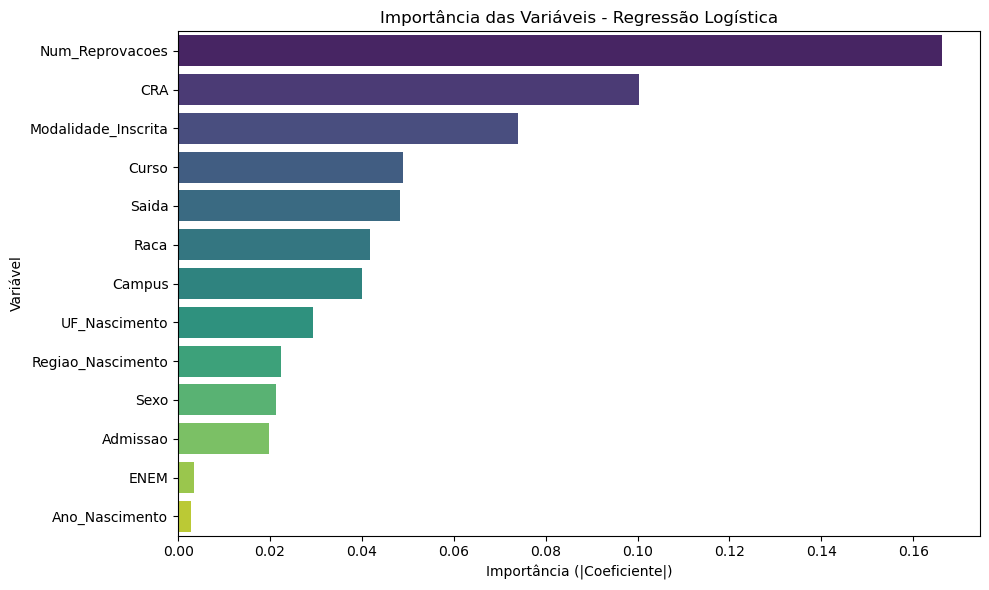

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 1. Separar features e target
X = df.drop(columns=["Situacao_Aluno_Agrupada"])
y = df["Situacao_Aluno_Agrupada"]

# 2. Separar 80% treino/validação e 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Codificar y para o modelo funcionar
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# 4. Definir modelo
model = LogisticRegression(max_iter=1000, random_state=42)

# 5. Ajustar o modelo com os dados de treino
model.fit(X_train, y_train_encoded)

# IMPORTÂNCIA DAS FEATURES (coeficientes absolutos)
# Se for um problema multiclasse, os coeficientes têm shape (n_classes, n_features)
if len(le.classes_) > 2:
    importances = np.mean(np.abs(model.coef_), axis=0)
else:
    importances = np.abs(model.coef_[0])

features = X.columns

# Organizar em dataframe para facilitar visualização
feat_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plotar
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_df, hue="Feature", palette="viridis", legend=False)
plt.title("Importância das Variáveis - Regressão Logística")
plt.xlabel("Importância (|Coeficiente|)")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

In [5]:
# Exibir os valores em uma célula separada
print(feat_df)

                Feature  Importance
9       Num_Reprovacoes    0.166230
11                  CRA    0.100402
7   Modalidade_Inscrita    0.073884
3                 Curso    0.048938
6                 Saida    0.048357
10                 Raca    0.041730
2                Campus    0.040006
4         UF_Nascimento    0.029374
12    Regiao_Nascimento    0.022367
1                  Sexo    0.021308
5              Admissao    0.019834
8                  ENEM    0.003499
0        Ano_Nascimento    0.002775


#### Considerando apenas **Evasão** ou **Não Evasão**

In [6]:
# Criando a nova coluna 'Evasao'
df['Situacao_Aluno_Agrupada'] = df['Situacao_Aluno_Agrupada'].astype(int)
df['Evasao'] = df['Situacao_Aluno_Agrupada'].apply(lambda x: 1 if x == 0 else 0)

In [7]:
# Quantidade de cada valor da nova coluna 'Evasao'
df['Evasao'].value_counts()

Evasao
1    1735
0    1510
Name: count, dtype: int64

In [8]:
# Validação dos valores
df[['Situacao_Aluno_Agrupada', 'Evasao']]

,Situacao_Aluno_Agrupada,Evasao
0,0,1
1,1,0
2,0,1
3,0,1
4,1,0
...,...,...
3240,0,1
3241,3,0
3242,0,1
3243,3,0


##### Sem validação cruzada e sem ajustes de parâmetros (resultado padrão)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
)

# Separar features (X) e target (y)
X = df.drop(columns=["Situacao_Aluno_Agrupada", "Evasao"])
y = df["Evasao"]

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo de regressão logística
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Fazer predições
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Matriz de probabilidades preditas para todas as classes

# Avaliar métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
auc_score = roc_auc_score(y_test, y_proba, multi_class="ovr", average="weighted")

# Exibir resultados
print("Métricas de Avaliação:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc_score:.4f}")

# Exibir relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

#-------------------------------------------------------------------------------
# Calcular Especificidade
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
specificities = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# Mostrar especificidade por classe
print("\nEspecificidade por classe:")
for cls, spec in zip(model.classes_, specificities):
    print(f"{cls}: {spec:.2f}")

# Calcular média ponderada da especificidade
labels, counts = np.unique(y_test, return_counts=True)
weights = counts / counts.sum()
weighted_specificity = np.average(specificities, weights=weights)
print(f"\nEspecificidade média ponderada: {weighted_specificity:.2f}")

Métricas de Avaliação:
Accuracy: 0.8659
Precision: 0.8681
Recall: 0.8659
F1 Score: 0.8661
AUC: 0.9244

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       301
           1       0.90      0.84      0.87       348

    accuracy                           0.87       649
   macro avg       0.87      0.87      0.87       649
weighted avg       0.87      0.87      0.87       649


Especificidade por classe:
0: 0.84
1: 0.89

Especificidade média ponderada: 0.87


##### Com validação cruzada e com ajustes de parâmetros (Grid Search CV)

In [13]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)
import numpy as np

# Separar X e y
X = df.drop(columns=["Situacao_Aluno_Agrupada", "Evasao"])
y = df["Evasao"]

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Grade de hiperparâmetros
param_grid = {
    'penalty': ['l2', 'none'],  # l1 exige solver diferente
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000]
}

# Modelo base
logreg = LogisticRegression(random_state=42)

# GridSearch
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=5,
    scoring='f1',  # pode ser 'roc_auc' ou outra
    n_jobs=-1,
    verbose=1
)

# Treinar
grid_search.fit(X_train, y_train)

# Melhor modelo
best_model = grid_search.best_estimator_

# Predições
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Avaliação
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
auc_score = roc_auc_score(y_test, y_proba, multi_class="ovr", average="weighted")

# Resultados
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

print("\nMétricas de Avaliação:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc_score:.4f}")

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Especificidade
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
specificities = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

print("\nEspecificidade por classe:")
for cls, spec in zip(best_model.classes_, specificities):
    print(f"{cls}: {spec:.2f}")

# Média ponderada
labels, counts = np.unique(y_test, return_counts=True)
weights = counts / counts.sum()
weighted_specificity = np.average(specificities, weights=weights)
print(f"\nEspecificidade média ponderada: {weighted_specificity:.2f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores parâmetros encontrados:
{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}

Métricas de Avaliação:
Accuracy: 0.8690
Precision: 0.8705
Recall: 0.8690
F1 Score: 0.8692
AUC: 0.9256

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       301
           1       0.90      0.85      0.87       348

    accuracy                           0.87       649
   macro avg       0.87      0.87      0.87       649
weighted avg       0.87      0.87      0.87       649


Especificidade por classe:
0: 0.85
1: 0.89

Especificidade média ponderada: 0.87


##### Com validação cruzada e sem ajustes de parâmetros 

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, make_scorer
)
import numpy as np

# 1. Separar features e target
X = df.drop(columns=["Situacao_Aluno_Agrupada", "Evasao"])
y = df["Evasao"]

# 2. Separar 80% treino/validação e 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Codificar y para ROC AUC funcionar
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# 4. Definir modelo de Regressão Logística
model = LogisticRegression(max_iter=1000, random_state=42)

# 5. Definir métricas para validação cruzada
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall_weighted': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0),
    'roc_auc_ovr_weighted': make_scorer(roc_auc_score, needs_proba=True, average='weighted', multi_class='ovr')
}

# 6. Validação cruzada nos 80% (treino/validação)
cv_results = cross_validate(
    model,
    X_train,
    y_train_encoded,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

# 7. Calcular média das métricas
metric_keys = ["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "roc_auc_ovr_weighted"]
metric_labels = ["Accuracy", "Precision", "Recall", "F1", "AUC"]

folds_data = []
for i in range(len(cv_results["test_accuracy"])):
    row = [i + 1] + [round(cv_results[f"test_{key}"][i], 3) for key in metric_keys]
    folds_data.append(row)

mean_row = ["Mean"] + [round(np.mean(cv_results[f"test_{key}"]), 3) for key in metric_keys]
folds_data.append(mean_row)

results_df = pd.DataFrame(folds_data, columns=["#", *metric_labels])

print(results_df)

#-------------------------------------------------------------------------------
from sklearn.metrics import confusion_matrix
# 8. Treinar com os 80% e testar nos 20%
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 9. Calcular matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# 10. Calcular especificidade por classe
specificities = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificities.append(specificity)

# 11. Exibir especificidade por classe
print("\nEspecificidade por classe (base de teste):")
for cls, spec in zip(model.classes_, specificities):
    print(f"{cls}: {spec:.2f}")

# 12. Calcular especificidade média ponderada (pelo y_test)
labels, counts = np.unique(y_test, return_counts=True)
weights = counts / counts.sum()
weighted_specificity = np.average(specificities, weights=weights)
print(f"\nEspecificidade média ponderada: {weighted_specificity:.2f}")

      #  Accuracy  Precision  Recall     F1    AUC
0     1     0.894      0.894   0.894  0.894  0.952
1     2     0.850      0.850   0.850  0.850  0.919
2     3     0.848      0.853   0.848  0.848  0.924
3     4     0.855      0.860   0.855  0.856  0.931
4     5     0.869      0.871   0.869  0.869  0.944
5  Mean     0.863      0.866   0.863  0.863  0.934

Especificidade por classe (base de teste):
0: 0.85
1: 0.89

Especificidade média ponderada: 0.87


##### Importância das Features

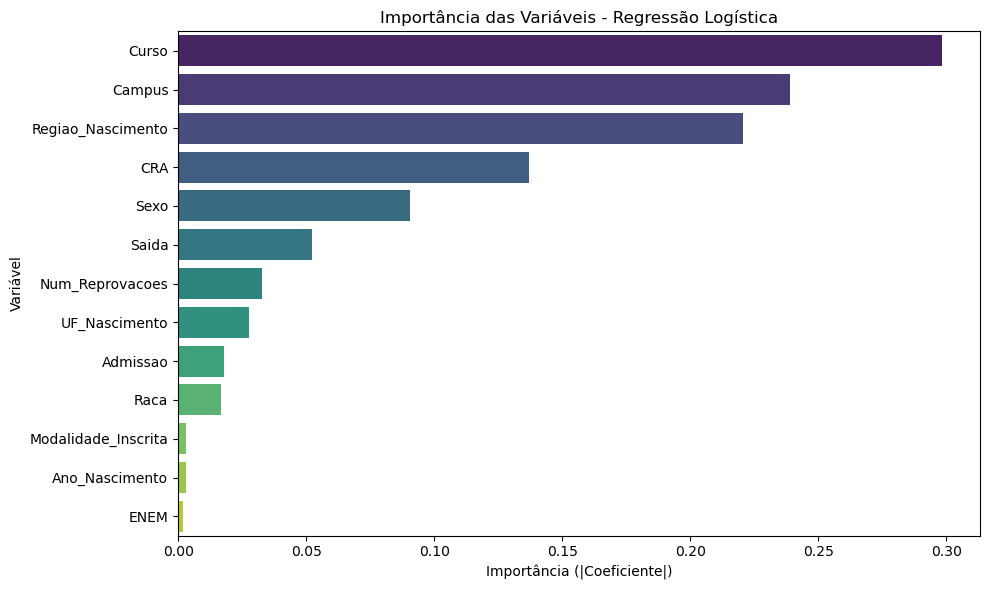

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 1. Separar features e target
X = df.drop(columns=["Situacao_Aluno_Agrupada", "Evasao"])
y = df["Evasao"]

# 2. Separar 80% treino/validação e 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Codificar y para o modelo funcionar
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# 4. Definir modelo
model = LogisticRegression(max_iter=1000, random_state=42)

# 5. Ajustar o modelo com os dados de treino
model.fit(X_train, y_train_encoded)

# IMPORTÂNCIA DAS FEATURES (coeficientes absolutos)
# Se for um problema multiclasse, os coeficientes têm shape (n_classes, n_features)
if len(le.classes_) > 2:
    importances = np.mean(np.abs(model.coef_), axis=0)
else:
    importances = np.abs(model.coef_[0])

features = X.columns

# Organizar em dataframe para facilitar visualização
feat_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plotar
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_df, hue="Feature", palette="viridis", legend=False)
plt.title("Importância das Variáveis - Regressão Logística")
plt.xlabel("Importância (|Coeficiente|)")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

In [12]:
# Exibir os valores em uma célula separada
print(feat_df)

                Feature  Importance
3                 Curso    0.298184
2                Campus    0.238797
12    Regiao_Nascimento    0.220482
11                  CRA    0.137013
1                  Sexo    0.090557
6                 Saida    0.052124
9       Num_Reprovacoes    0.032663
4         UF_Nascimento    0.027810
5              Admissao    0.017840
10                 Raca    0.016609
7   Modalidade_Inscrita    0.002978
0        Ano_Nascimento    0.002931
8                  ENEM    0.001931
